In [40]:
import yaml
from util import ks_weighted
import hist
import numpy as np
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# from sort_jets import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import cloudpickle
import os
from scipy import stats
import datetime
from sklearn.metrics import mean_squared_error

2022-12-20 18:25:51.820324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 18:25:52.843762: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-20 18:25:52.935872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 18:25:52.936316: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [41]:
with open('config.yaml') as conf_file:
    config = yaml.load(conf_file, Loader=yaml.Loader) 

In [3]:
# creates sh file to merge the ggf samples
# import sys,os
# def write_file(process):
#     outfilename = f"merge_{process}_files.sh"
#     outfile = open(outfilename, 'w')
#     #lxplus path
#     # path = "/afs/cern.ch/user/c/cchavezr/samples/without_vbf_filter/nn_tagged/"
#     #eos path
#     path = "/home/cristobalchavez21/notebooks/Samples/"
#     out_path = "/home/cristobalchavez21/notebooks/Samples/latest/merged/"
#     outfile.write("#! /bin/sh\n")
#         #Samples/508885_r9364.root
#     for n_dsid in range(508885, 508894):
#         dsid = str(n_dsid)
#         command = f"hadd {out_path}frvz_{process}_{dsid}.root {path+dsid}_r9364.root {path+dsid}_r10201.root {path+dsid}_r10724.root\n"
#         outfile.write(command)

#     os.system("chmod u+x %s" %(outfilename))
#     outfile.close()
#     return
# write_file("ggf")

#### Prepare the cuted files 

In [42]:
do_cut = 0
with_VBF_cut = False
if with_VBF_cut:
    VBF_cut = '_with_VBF_cut'
else:
    VBF_cut = '_without_VBF_cut'


#### get cuted files 

In [43]:
s_x_train_norm = np.load("output/train_test/signal_x_train_norm.npy")
s_w_train = np.load("output/train_test/signal_w_train.npy")
s_y_train = np.load("output/train_test/signal_y_train.npy")
b_x_train_norm = np.load("output/train_test/bkg_x_train_norm.npy")
b_w_train = np.load("output/train_test/bkg_w_train.npy")
b_y_train = np.load("output/train_test/bkg_y_train.npy")

s_x_val_norm = np.load("output/train_test/signal_x_val_norm.npy")
s_w_val = np.load("output/train_test/signal_w_val.npy")
s_y_val = np.load("output/train_test/signal_y_val.npy")
b_x_val_norm = np.load("output/train_test/bkg_x_val_norm.npy")
b_w_val = np.load("output/train_test/bkg_w_val.npy")
b_y_val = np.load("output/train_test/bkg_y_val.npy")

In [44]:
BDT_inputs = ["jets_pt_sorted", "jets_eta_sorted", "jets_phi_sorted",
                "jets_e_sorted"
             ]
max_jets = 6

In [48]:
val_x = np.concatenate([s_x_val_norm, b_x_val_norm], axis=0)
val_y = np.concatenate([s_y_val, b_y_val])
val_w = np.concatenate([s_w_val, b_w_val], axis=0)

In [105]:
BUFFER_SIZE = 700000

def make_ds(features, labels, weights):
  ds = tf.data.Dataset.from_tensor_slices((features, labels, weights))
  ds = ds.shuffle(BUFFER_SIZE).cache().repeat()
  return ds

s_ds = make_ds(s_x_train_norm, s_y_train, s_w_train)
b_ds = make_ds(b_x_train_norm, b_y_train, b_w_train)

2022-12-15 14:21:33.681319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-15 14:21:33.682145: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 14:21:33.682397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MSI): /proc/driver/nvidia/version does not exist
2022-12-15 14:21:33.691907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [106]:
n=34000
s_w_sum = s_w_train[:n].sum()
b_w_sum = b_w_train[:n].sum()
train_w_sum = s_w_sum + b_w_sum
print(f"Weighted sum of training signal events: {s_w_sum}")
print(f"Weighted sum of training bkg events: {b_w_sum}")
print(f"Signal weighted events are : {100*s_w_sum/train_w_sum}%")
print(f"Bkg weighted events are : {100*b_w_sum/train_w_sum}%")
print(f"On average each signal event weights: {s_w_sum/n}")
print(f"On average each bkg event weights: {b_w_sum/n}")

Weighted sum of training signal events: 786.86376953125
Weighted sum of training bkg events: 48823.8125
Signal weighted events are : 1.586077506786633%
Bkg weighted events are : 98.41392347743952%
On average each signal event weights: 0.023143052045036763
On average each bkg event weights: 1.4359944852941176


In [10]:
# Randomly selects events from signal and bkg with more probability of selecting signal
# So if a number of events are selected, the weighted sum of the signal and bkg will be similar
BATCH_SIZE = 256
prob_s = 0.984
prob_b = 1 - prob_s
resampled_ds = tf.data.Dataset.sample_from_datasets([s_ds, b_ds], weights=[prob_s, prob_b])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y, val_w)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 

# number of batches necessary to use each bkg event once
resampled_steps_per_epoch = np.ceil((len(b_w_train))/(BATCH_SIZE*prob_b))
# resampled_steps_per_epoch

# resampled_ds.as_numpy_iterator().__next__()

In [11]:
METRICS = [ 
  # 'accuracy',
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
    #   keras.metrics.BinaryAccuracy(name='accuracy'),
    #   keras.metrics.Precision(name='precision'),
      keras.metrics.BinaryCrossentropy(name='crossentropy'),
      keras.metrics.MeanSquaredError(name='mse'),
      # keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.0006,
#   decay_steps=30*resampled_steps_per_epoch, #lr decays to half after 30 epochs
#   decay_rate=1,
#   staircase=False)

# entrada si es entre 0 y 1 relu y si -1 a 1 elu/relu o leakyrelu

initial_bias = tf.keras.initializers.Constant([0.0]) #math.log(len(s_f)/len(b_f))])
#dropout como enfermo 


combined_model = tf.keras.Sequential()

# masking layer to ignore the padding zeros 
combined_model.add(layers.Masking(mask_value=0., input_shape=(max_jets, len(BDT_inputs))))

combined_model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))#, kernel_regularizer=regularizers.l2(0.0001)))

# combined_model.add(layers.Dropout(0.3))
# combined_model.add(layers.BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

# combined_model.add(layers.LSTM(128, return_sequences=True, activation='tanh'))#, kernel_regularizer=regularizers.l2(0.0001)))
# combined_model.add(layers.Dropout(0.3))
# combined_model.add(layers.BatchNormalization())

combined_model.add(layers.Bidirectional(layers.LSTM(16)))#, kernel_regularizer=regularizers.l2(0.0001)))
# combined_model.add(layers.Dropout(0.3))
# combined_model.add(layers.BatchNormalization())

combined_model.add(layers.Dense(10, activation='relu'))#, kernel_regularizer=regularizers.l2(0.0001)))
# combined_model.add(layers.Dropout(0.3))

combined_model.add(layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias))


combined_model.compile(
      loss="binary_crossentropy",
      # metrics=METRICS,
      weighted_metrics=METRICS,
      optimizer=tf.keras.optimizers.Adam(
        learning_rate = 0.00005
    # learning_rate=lr_schedule
))

combined_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 6, 4)              0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 64)            9472      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,181
Trainable params: 20,181
Non-traina

In [12]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) 
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    patience=10, restore_best_weights=True)

history = combined_model.fit(
    resampled_ds,
    callbacks=[tensorboard_callback,early_stopping_callback],
    verbose=1, epochs=200, steps_per_epoch=resampled_steps_per_epoch,
    validation_data=val_ds,    
    )

Epoch 1/200
259900/259900 [==============================] - 3605s 14ms/step - loss: 0.0080 - crossentropy: 0.1797 - mse: 0.0502 - auc: 0.9780 - val_loss: 0.1806 - val_crossentropy: 0.1687 - val_mse: 0.0479 - val_auc: 0.9809
Epoch 2/200
259900/259900 [==============================] - 3670s 14ms/step - loss: 0.0071 - crossentropy: 0.1605 - mse: 0.0442 - auc: 0.9819 - val_loss: 0.1789 - val_crossentropy: 0.1671 - val_mse: 0.0469 - val_auc: 0.9816
Epoch 3/200
259900/259900 [==============================] - 3713s 14ms/step - loss: 0.0070 - crossentropy: 0.1577 - mse: 0.0433 - auc: 0.9824 - val_loss: 0.1747 - val_crossentropy: 0.1632 - val_mse: 0.0455 - val_auc: 0.9819
Epoch 4/200
259900/259900 [==============================] - 3737s 14ms/step - loss: 0.0069 - crossentropy: 0.1563 - mse: 0.0429 - auc: 0.9827 - val_loss: 0.1788 - val_crossentropy: 0.1671 - val_mse: 0.0464 - val_auc: 0.9820
Epoch 5/200
259900/259900 [==============================] - 3742s 14ms/step - loss: 0.0069 - crosse

##### Validation

In [109]:
s_x_test_norm = np.load("output/train_test/signal_x_test_norm.npy")
s_w_test = np.load("output/train_test/signal_w_test.npy")
s_y_test = np.load("output/train_test/signal_y_test.npy")
b_x_test_norm = np.load("output/train_test/bkg_x_test_norm.npy")
b_w_test = np.load("output/train_test/bkg_w_test.npy")
b_y_test = np.load("output/train_test/bkg_y_test.npy")

In [49]:
# test_x = np.concatenate([s_x_test_norm, b_x_test_norm], axis=0)
# test_y = np.concatenate([s_y_test, b_y_test])
# test_w = np.concatenate([s_w_test, b_w_test], axis=0)

train_x = np.concatenate([s_x_train_norm, b_x_train_norm], axis=0)
train_y = np.concatenate([s_y_train, b_y_train])
train_w = np.concatenate([s_w_train, b_w_train])

In [111]:
del b_ds
del b_w_sum
del b_w_test
del b_w_train
del b_w_val
del b_y_train
del b_x_train_norm
del b_x_test_norm
del b_x_val_norm
del b_y_test
del b_y_val
del s_ds
del s_w_sum
del s_w_test
del s_w_train
del s_w_val
del s_x_test_norm
del s_x_train_norm
del s_x_val_norm
del s_y_test
del s_y_train
del s_y_val

In [50]:
# load saved model
combined_model = tf.keras.models.load_model("models/rnn/04-12_00:16:43/rnn_32_16_10_val_auc_10_lr_0.00005_BS_256")
# combined_model = tf.keras.models.load_model("models/rnn/01-12_14:25:08/rnn_64_32_10_val_auc_7")

2022-12-20 18:30:05.184690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-20 18:30:05.186132: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-20 18:30:05.186485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MSI): /proc/driver/nvidia/version does not exist
2022-12-20 18:30:05.194393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
# y_pred_test = combined_model.predict(test_x)
y_pred_train = combined_model.predict(train_x).flatten()
y_pred_val = combined_model.predict(val_x).flatten()
# Y_test = y_test
# pd.DataFrame(y_pred_test).hist(density=True)

9442/9442 [==============================] - 25s 3ms/step


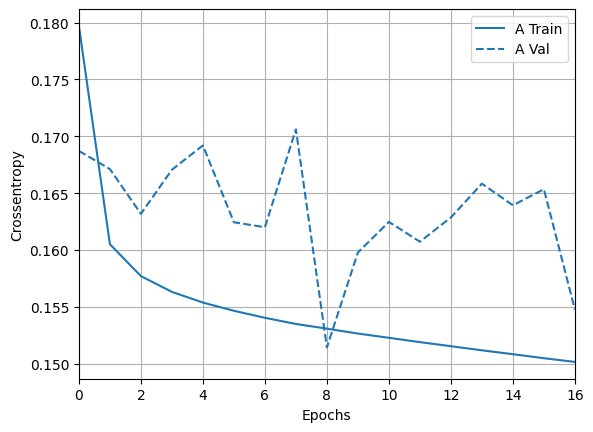

In [21]:
#  !pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
# plotter = tfdocs.plots.HistoryPlotter(metric = 'mse')
plotter = tfdocs.plots.HistoryPlotter(metric = 'crossentropy')
# plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
# plotter = tfdocs.plots.HistoryPlotter(metric = 'auc')

plotter.plot({"a":history})
# plt.ylim([0.5, 0.7])

In [52]:
mean_squared_error(val_y, y_pred_val)

0.04408970980268888

In [ ]:
train_y

In [53]:
sig_stats = stats.ks_2samp(y_pred_val[val_y == True],y_pred_train[train_y == True])
bkg_stats = stats.ks_2samp(y_pred_val[val_y == False],y_pred_train[train_y == False])
sig_p_v = sig_stats.pvalue
bkg_p_v = bkg_stats.pvalue

In [54]:
#define the hist
bins = 30

h = hist.Hist.new.Reg(bins=bins, start=0, stop=1, name="RNN response")    \
    .StrCat(categories=["Train VBF","Train ggF", "Val VBF" ,"Val ggF"
    # , "val VBF", "val ggF"
    ], name="data") \
    .Double()

#fill the hist
# h = h.fill(y_pred_test[y_test == True],  data="Test VBF") #weight=w_test[y_test == True],
# h = h.fill(y_pred_test[y_test == False],  data="Test ggF") #weight=w_test[y_test == False],

h = h.fill(y_pred_val[val_y == True],  data="Val VBF") 
h = h.fill(y_pred_val[val_y == False],  data="Val ggF")

h = h.fill(y_pred_train[train_y == True],  data="Train VBF") #weight=w_train[y_train == True],
h = h.fill(y_pred_train[train_y == False],  data="Train ggF") #weight=w_train[y_train == False],

# print(f"The signal(background) p-value in Kolmogorov-Smirnov test is: {signal_test.pvalue:.5f}({bkg_test.pvalue:.5f}) ")
# print(f"The KS statistic is: {signal_test.statistic}({bkg_test.statistic})")


plot1 = h.stack("data")
plot1

Stack<('Train VBF', 'Train ggF', 'Val VBF', 'Val ggF') of Hist(Regular(30, 0, 1, name='RNN response'), storage=Double()) # Sum: 343730.0>

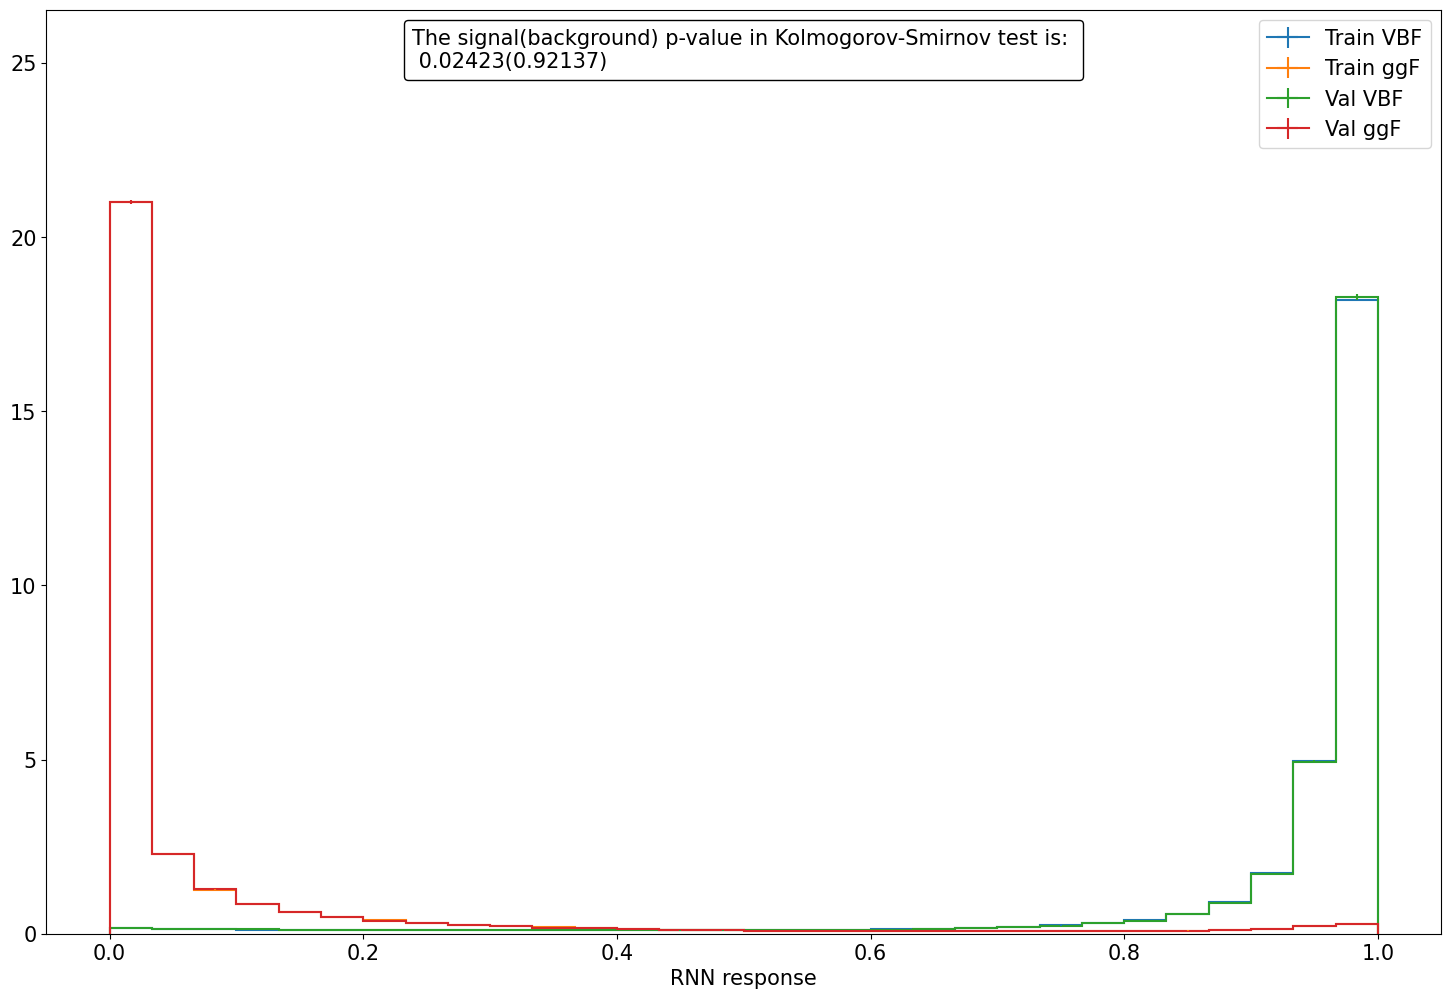

In [55]:
# plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
at = AnchoredText(
    f"The signal(background) p-value in Kolmogorov-Smirnov test is: \n {sig_p_v:.5f}({bkg_p_v:.5f})",
    prop=dict(size=15),
    frameon=True,
    loc='upper center')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
plot1.plot(density=True, ax=ax)
ax.set_ylim(top=ax.get_ylim()[1]*6/5)
plt.legend(loc="upper right")
# fig.show()
# model_dir = datetime.datetime.now().strftime("%d-%m_%H:%M:%S")
# path = "models/rnn/"+model_dir+"/plots/"
# os.makedirs(os.path.dirname(path), exist_ok=True)
# plt.savefig(f"{path}k-s_plot.pdf")

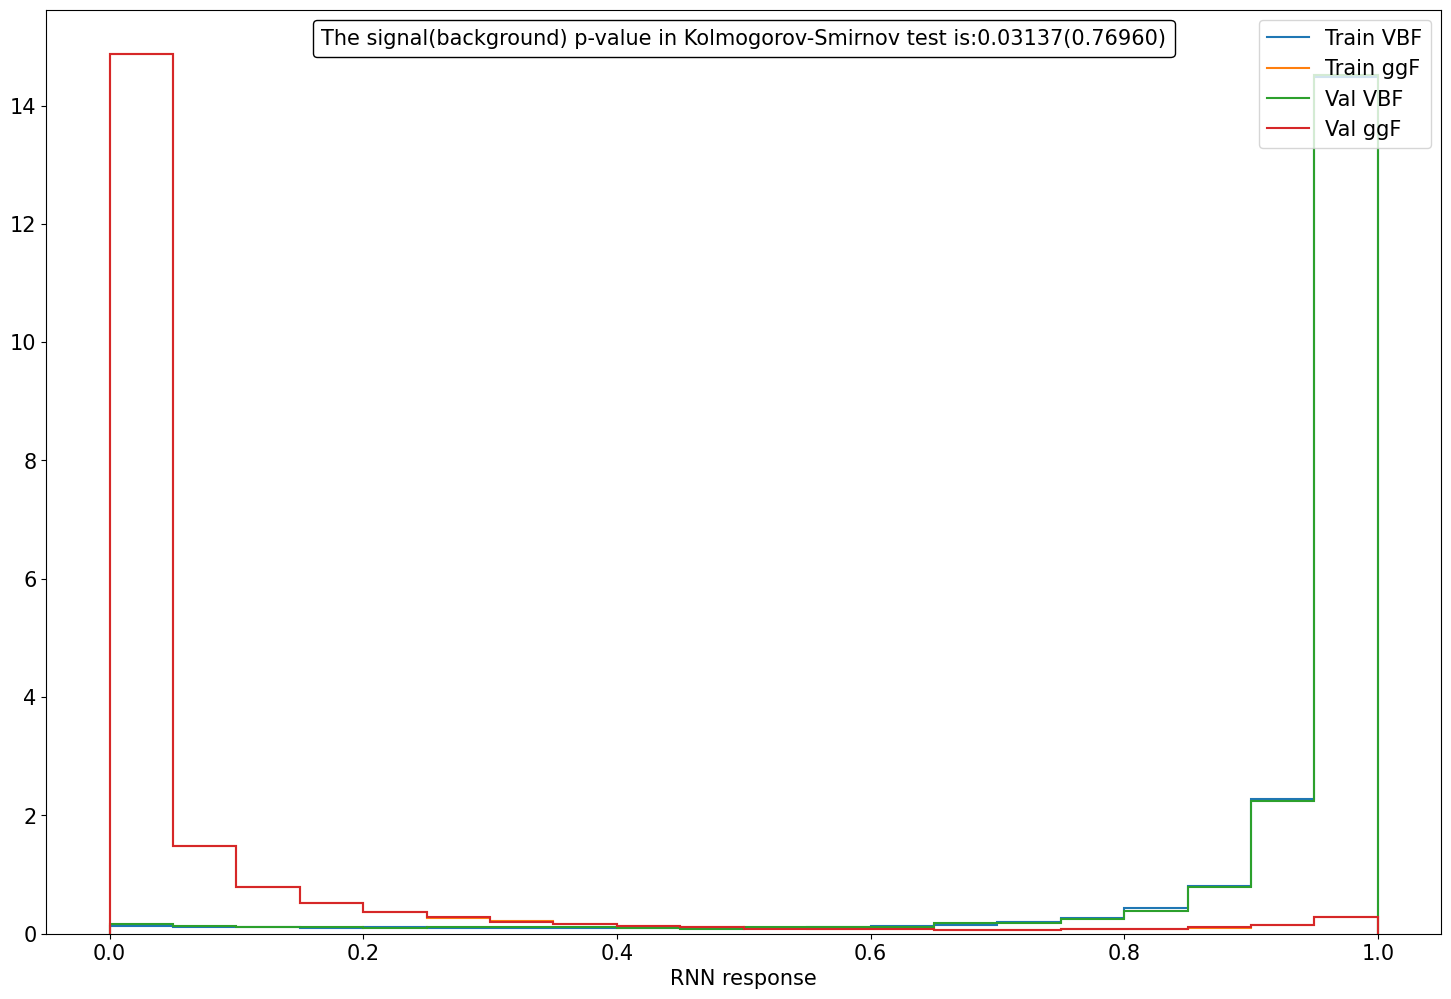

In [118]:
h = hist.Hist.new.Reg(bins=bins, start=0, stop=1, name="RNN response")    \
        .StrCat(categories=["Train VBF","Train ggF", "Val VBF" ,"Val ggF"], name="data") \
        .Double()

#fill the hist
h = h.fill(y_pred_val[val_y == True], weight=val_w[val_y == True], data="Val VBF") #
h = h.fill(y_pred_val[val_y == False], weight=val_w[val_y == False], data="Val ggF") #

h = h.fill(y_pred_train[train_y == True], weight=train_w[train_y == True], data="Train VBF") #
h = h.fill(y_pred_train[train_y == False], weight=train_w[train_y == False], data="Train ggF") #

plot1 = h.stack("data")
plot1

sig_stat_w, sig_p_v_w = ks_weighted(y_pred_val[val_y == True], y_pred_train[train_y == True], val_w[val_y == True], train_w[train_y == True] , alternative='two-sided')
bkg_stat_w, bkg_p_v_w = ks_weighted(y_pred_val[val_y == False], y_pred_train[train_y == False], val_w[val_y == False], train_w[train_y == False] , alternative='two-sided')

fig, ax = plt.subplots()
at = AnchoredText(
    f"The signal(background) p-value in Kolmogorov-Smirnov test is:{sig_p_v_w:.5f}({bkg_p_v_w:.5f})",
    prop=dict(size=15),
    frameon=True,
    loc='upper center')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
plot1.plot(density=True, ax=ax)
plt.legend(loc="upper right")
# fig.show()
plt.savefig(f"{path}k-s_plot_weighted.pdf")

In [27]:
model_dir = datetime.datetime.now().strftime("%d-%m_%H:%M:%S")
path = "models/rnn/"+model_dir+"/"
os.makedirs(os.path.dirname(path), exist_ok=True)
with open(path+"rnn_32_16_10_val_auc_10_lr_0.00005_BS_256.pkl", "wb") as o_file:
    cloudpickle.dump(combined_model, o_file)
# path

INFO:tensorflow:Assets written to: ram://214443f5-6cef-4d59-8a8c-9a8341c34edd/assets


INFO:tensorflow:Assets written to: ram://214443f5-6cef-4d59-8a8c-9a8341c34edd/assets


In [49]:
combined_model.save(path+"rnn_32_16_10_val_auc_10_lr_0.00005_BS_256")

INFO:tensorflow:Assets written to: models/rnn/04-12_00:16:43/rnn_32_16_10_val_auc_10_lr_0.00005_BS_256/assets


INFO:tensorflow:Assets written to: models/rnn/04-12_00:16:43/rnn_32_16_10_val_auc_10_lr_0.00005_BS_256/assets
